<a href="https://colab.research.google.com/github/phrsouza/git/blob/master/credit_card_fraud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
# import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive
from matplotlib_venn import venn2

# %pip install clusteval
# from clusteval import cluster_similarity


# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import r2_score #método para o cálculo do R2
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import jaccard_score #Used

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC

In [2]:
# Read dataset and print types
drive.mount('/content/drive')
df = pd.read_csv(
    '/content/drive/MyDrive/CloudWalk/transactional-sample.csv',
    sep=',',
    dtype={
        'transanction_id': int,
        'merchant_id': int,
        'user_id': int,
        'card_number': str,
        'transaction_amount': float,
        'device_id': 'Int64',
        'has_cbk': bool
        },
    parse_dates=['transaction_date'],
    na_values=['']
)
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3199 non-null   int64         
 1   merchant_id         3199 non-null   int64         
 2   user_id             3199 non-null   int64         
 3   card_number         3199 non-null   object        
 4   transaction_date    3199 non-null   datetime64[ns]
 5   transaction_amount  3199 non-null   float64       
 6   device_id           2369 non-null   Int64         
 7   has_cbk             3199 non-null   bool          
dtypes: Int64(1), bool(1), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 181.3+ KB


87.77742981910706
12.222569435834885


([<matplotlib.patches.Wedge at 0x7e8d624e8a30>,
 [Text(-1.019897735472416, 0.4120784017371426, 'Legit'),
  Text(1.0198977258270245, -0.41207842560957225, 'Fraud')],
 [Text(-0.5563078557122269, 0.22477003731116868, '87.7774%\n(2808)'),
  Text(0.5563078504511042, -0.22477005033249392, '12.2226%\n(391)')])

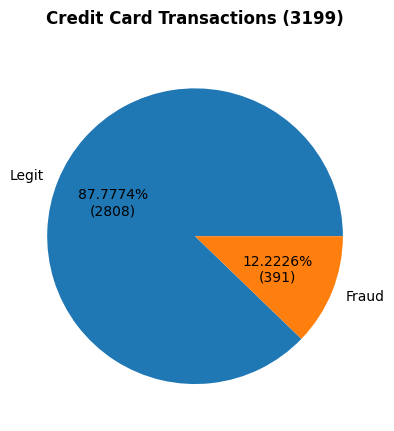

In [4]:
# Frauds proportion analysis by amount
total_legit = df.has_cbk.value_counts()[False]
total_frauds = df.has_cbk.value_counts()[True]
total = total_legit + total_frauds

def format_percentagel_with_value(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total*x/100)

data = [total_legit, total_frauds]
labels = 'Legit', 'Fraud'
fig, ax = plt.subplots()
ax.set_title('Credit Card Transactions ({})'.format(total), fontweight='bold', pad=20)
ax.pie(data, labels=labels, autopct=format_percentagel_with_value)


Disbalanced proportion of Legit and Fraud. Specific threatment needed before training model, otherwise it will be good at predincting Legits and bad for predicting Frauds

In [46]:
# Statistic data for transaction_amount
df[['transaction_amount']].describe()

,transaction_amount
count,3199.000000
mean,767.812904
std,889.095904
min,1.220000
25%,205.235000
50%,415.940000
75%,981.680000
max,4097.210000


Text(0.5, 1.0, 'Transaction Amount boxplot')

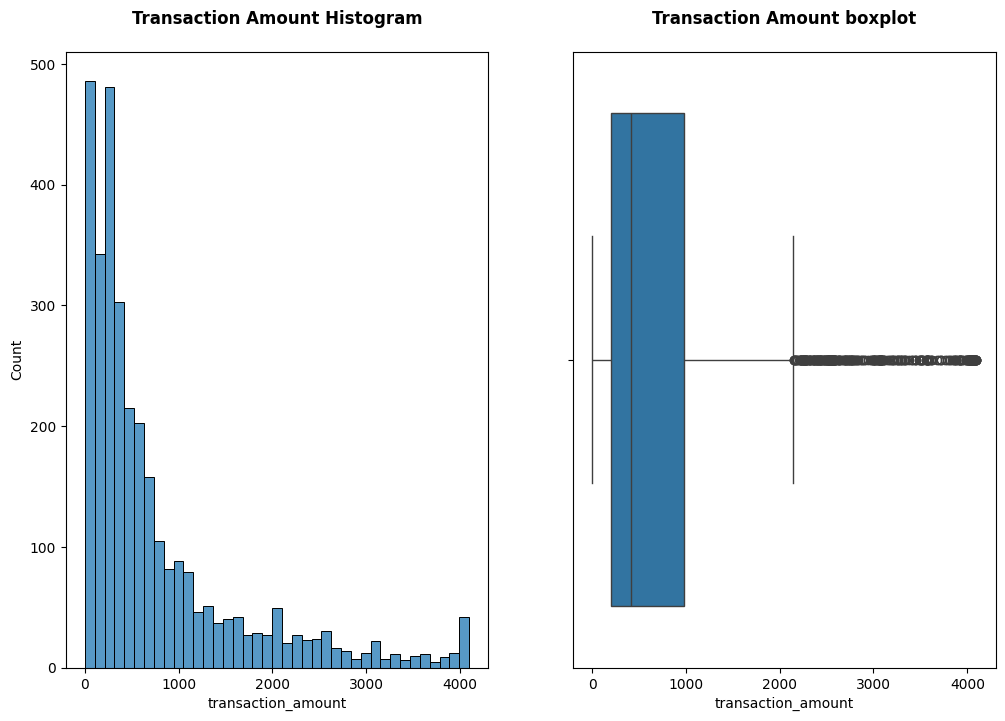

In [6]:
# Transaction amount histogram and boxplot
fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.histplot(df.transaction_amount, ax=ax[0]).set_title("Transaction Amount Histogram", fontweight='bold', pad=20)
sns.boxplot(x=df.transaction_amount, ax=ax[1]).set_title('Transaction Amount boxplot', fontweight='bold', pad=20)


89.00255560874939
10.997442156076431
53.2608687877655
46.7391312122345
75.44757127761841
24.55243021249771
67.6767647266388
32.32323229312897


([<matplotlib.patches.Wedge at 0x7e8d5ffbfa90>,
 [Text(-0.5799479277427769, 0.9346980266946426, 'Legit IQR outliers'),
  Text(0.5799478402300293, -0.9346980809932823, 'Fraud IQR outliers')],
 [Text(-0.31633523331424196, 0.5098352872879868, '67.6768%\n(201)'),
  Text(0.316335185580016, -0.5098353169054266, '32.3232%\n(96)')])

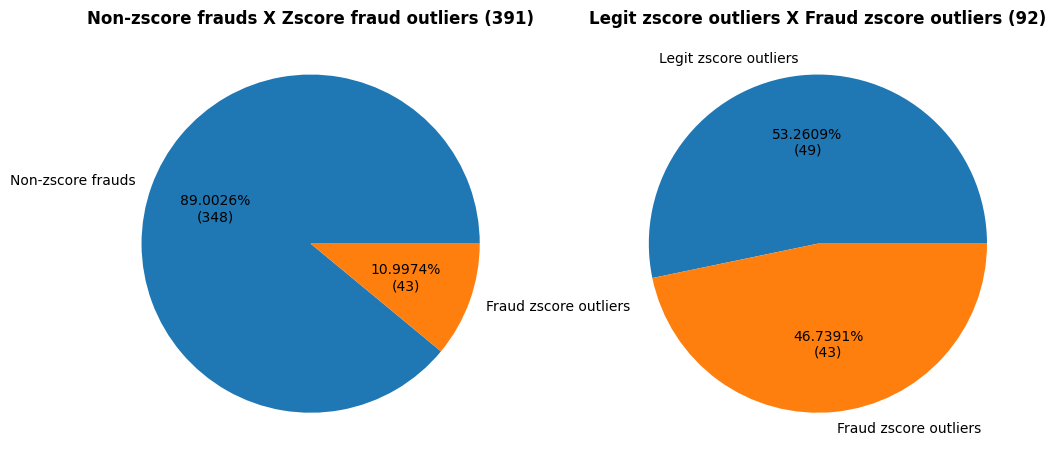

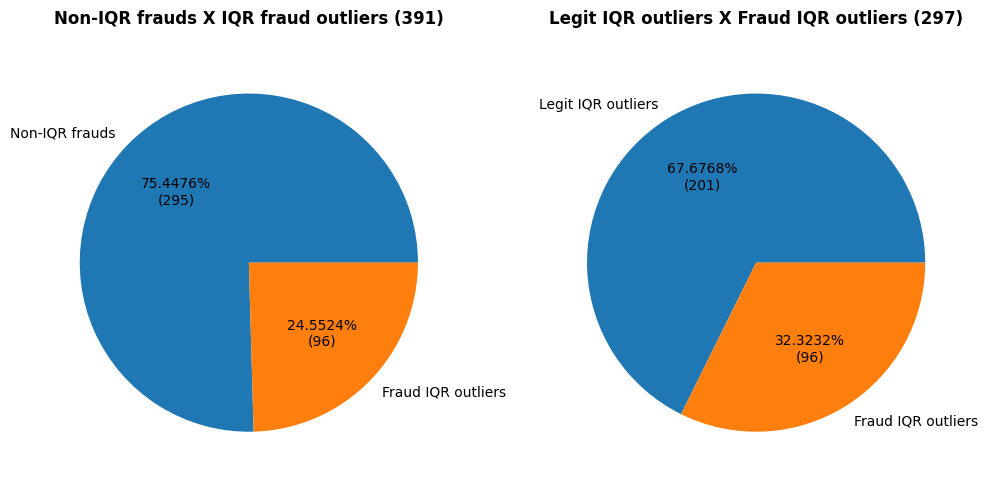

In [8]:
# Transaction amount outliers analysis
# --- Zscore ----
zscore_outliers = df[np.abs(stats.zscore(df.transaction_amount)) > 3]
total_frauds_zscore_outliers = zscore_outliers.has_cbk.value_counts()[True]
total_legit_zscore_outliers = zscore_outliers.has_cbk.value_counts()[False]
total_frauds = df.has_cbk.value_counts()[True]

# total frauds X total outliers fraud piechart
def format_percentage_with_value(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total_frauds*x/100)
zscore_outliers_data = [total_frauds - total_frauds_zscore_outliers, total_frauds_zscore_outliers]
zscore_outliers_labels = 'Non-zscore frauds', 'Fraud zscore outliers'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.set_title('Non-zscore frauds X Zscore fraud outliers ({})'.format(total_frauds), fontweight='bold')
ax1.pie(zscore_outliers_data, labels=zscore_outliers_labels, autopct=format_percentage_with_value)


total_zscore_outliers = total_frauds_zscore_outliers + total_legit_zscore_outliers
zscore_outliers_legit_fraud_data = [total_legit_zscore_outliers, total_frauds_zscore_outliers]
zscore_outliers_legit_fraud_labels = ["Legit zscore outliers", "Fraud zscore outliers"]
def format_percentage_with_value(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total_zscore_outliers*x/100)
ax2.set_title('Legit zscore outliers X Fraud zscore outliers ({})'.format(total_zscore_outliers), fontweight='bold')
ax2.pie(zscore_outliers_legit_fraud_data, labels=zscore_outliers_legit_fraud_labels, autopct=format_percentage_with_value)


# --- IQR ---
# # calculate IQR for transaction_amount
Q1 = df.transaction_amount.quantile(0.25)
Q3 = df.transaction_amount.quantile(0.75)
IQR = Q3 - Q1

# # identify outliers
threshold = 1.5
# # drop rows containing irq_outliers
# df.describe()
# df_iqr = df.copy().drop(irq_outliers.index)
iqr_outliers = df[(df.transaction_amount < Q1 - threshold * IQR) | (df.transaction_amount > Q3 + threshold * IQR)]
total_frauds_iqr_outliers = iqr_outliers.has_cbk.value_counts()[True]
total_legit_iqr_outliers = iqr_outliers.has_cbk.value_counts()[False]
total_frauds = df.has_cbk.value_counts()[True]

# total frauds X total outliers fraud piechart
def format_percentage_with_value(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total_frauds*x/100)
iqr_outliers_data = [total_frauds - total_frauds_iqr_outliers, total_frauds_iqr_outliers]
iqr_outliers_labels = 'Non-IQR frauds', 'Fraud IQR outliers'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.set_title('Non-IQR frauds X IQR fraud outliers ({})'.format(total_frauds), fontweight='bold', pad=20)
ax1.pie(
    iqr_outliers_data, labels=iqr_outliers_labels, autopct=format_percentage_with_value)


total_iqr_outliers = total_frauds_iqr_outliers + total_legit_iqr_outliers
iqr_outliers_legit_fraud_data = [total_legit_iqr_outliers, total_frauds_iqr_outliers]
iqr_outliers_legit_fraud_labels = ["Legit IQR outliers", "Fraud IQR outliers"]
def format_percentage_with_value(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total_iqr_outliers*x/100)
ax2.set_title('Legit IQR outliers X Fraud IQR outliers ({})'.format(total_iqr_outliers), fontweight='bold', pad=20)
ax2.pie(iqr_outliers_legit_fraud_data, labels=iqr_outliers_legit_fraud_labels, autopct=format_percentage_with_value)




By removing zscore outliers, we would remove > 10% of total frauds from the dataset

By removing IQR outliers, we would remove > 24% of total frauds from the dataset

**Both outliers identification methods remove a significant amount of frauds, so lets keep them**

In [52]:
# Histograms of legit and fraudulent transactions by transaction_amount'
## set variables with legit and fraud transactions <= 500 euros
legit_df = df.loc[df.has_cbk == False]
fraud_df = df[df.has_cbk == True]


fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(legit_df.transaction_amount, bins=20, ax=ax, kde=False, color='g')
combined_frequency_plot = sns.histplot(fraud_df.transaction_amount, bins=20, ax=ax, kde=False, color='r')
combined_frequency_plot.legend(labels=['legit','fraud'])
combined_frequency_plot.set_title("Transaction amount frequencies", fontweight='bold', pad=20)
combined_frequency_plot.set_xticks(range(0, 4001, 500))

# fig.legend(labels=['legit','fraud'], loc='upper center')
# ax.set_ylim([0, 100])

# Legit chart
fig, ax = plt.subplots(1, 2, figsize=(12,8))
legit_plot = sns.histplot(
    x=legit_df.transaction_amount, bins=20, ax=ax[0], color='g', kde=True
    )
legit_plot.legend(labels=["legit"])
legit_plot.set_title("Legit Transactions Frequency by Amount", fontweight='bold', pad=20)
legit_plot.set_xticks(range(0, 4001, 500))
legit_bar_labels = []
for p in legit_plot.patches:
    h = p.get_height()
    legit_bar_labels.append(str(h) if h else '')
legit_plot.bar_label(legit_plot.containers[0], labels=legit_bar_labels)
# legit_plot.set_xticks(range(0, 4001, 500))


# Fraud chard
fraud_plot = sns.histplot(
  x=fraud_df.transaction_amount, bins=20, ax=ax[1], color='r', kde=True
  )
fraud_plot.legend(labels=["fraud"])
fraud_plot.set_title("Fraud Transactions Frequency by Amount", fontweight='bold', pad=20)
fraud_plot.set_xticks(range(0, 4001, 500))
fraud_bar_labels = []
for p in fraud_plot.patches:
    h = p.get_height()
    fraud_bar_labels.append(str(h) if h else '')
fraud_plot.bar_label(fraud_plot.containers[0], labels=fraud_bar_labels)


<Axes: title={'center': 'Transaction amount frequencies'}, xlabel='transaction_amount', ylabel='Count'>

* Legit: The higher is the amout, the lower is the frequency. Peak 0-500
* Fraud: Peak 250-1000.
* ~50% of transactions above 50% are frauds.

Fraud occur for higher values?

Legit        transaction_amount
count         2808.000000
mean           672.324380
std            797.463853
min              1.220000
25%            191.285000
50%            360.315000
75%            812.577500
max           4091.830000
Fraud        transaction_amount
count          391.000000
mean          1453.571918
std           1169.491346
min              2.890000
25%            565.580000
50%            999.470000
75%           2140.680000
max           4097.210000


<Axes: title={'center': 'Transaction amount correlation'}>

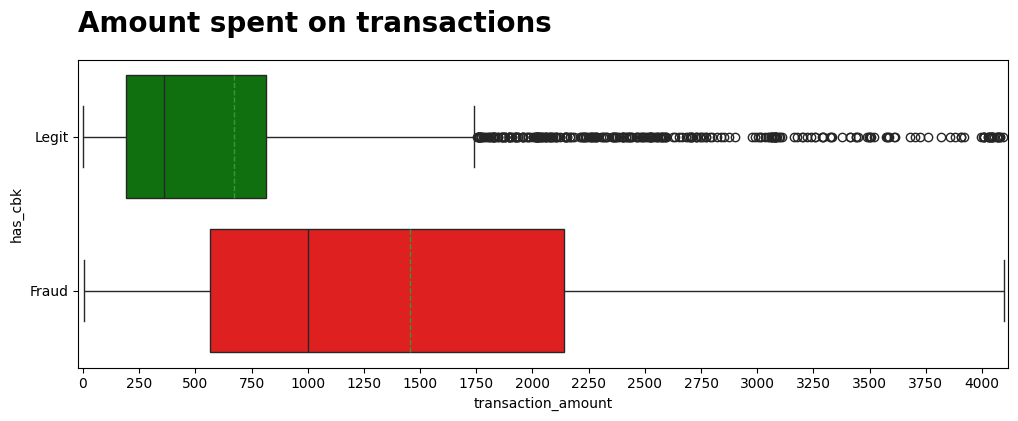

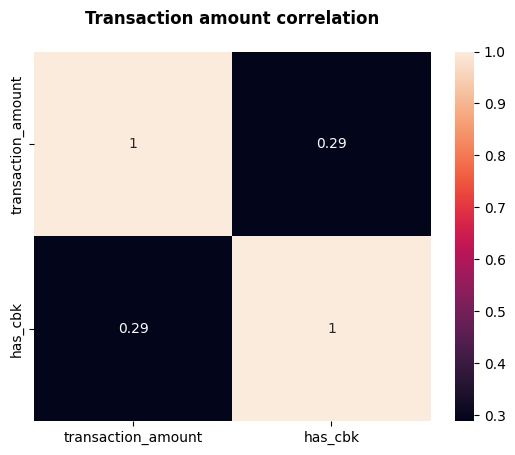

In [23]:
print("Legit", legit_df[['transaction_amount']].describe())
print("Fraud", fraud_df[['transaction_amount']].describe())

fig, ax = plt.subplots(figsize=(12,4))

sns.boxplot(x=df.transaction_amount, y=df.has_cbk, orient='h', meanline=True, showmeans=True,
            palette=['g', 'r'], hue=df.has_cbk, legend=False)
plt.xlim((-20, df.transaction_amount.max() + 20))
plt.xticks(range(0, 4001, 250))
plt.yticks([0, 1], ['Legit', 'Fraud'])
plt.title('Amount spent on transactions', loc='left', fontsize=20, fontweight='bold', pad=20)


# Correlation matrix
fig, ax = plt.subplots()
ax.set_title("Transaction amount correlation", fontweight='bold', pad=20)
corr = df[['transaction_amount', 'has_cbk']].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True)


* Legit mean: 672.324380
* Legit 75%: 812.577500

* Fraud mean: 1453.571918
* Fraud 75%: 2140.680000

* Weak correlation(0.1 < corr< 0.5) between transaction amount and has_cbk:
Frauds occur for higher amounts

[Text(0, 0, '24'),
 Text(0, 0, '14'),
 Text(0, 0, '18'),
 Text(0, 0, '4'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '1'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '5'),
 Text(0, 0, '9'),
 Text(0, 0, '11'),
 Text(0, 0, '16'),
 Text(0, 0, '18'),
 Text(0, 0, '30'),
 Text(0, 0, '31'),
 Text(0, 0, '23'),
 Text(0, 0, '44'),
 Text(0, 0, '37'),
 Text(0, 0, '42'),
 Text(0, 0, '29'),
 Text(0, 0, '35')]

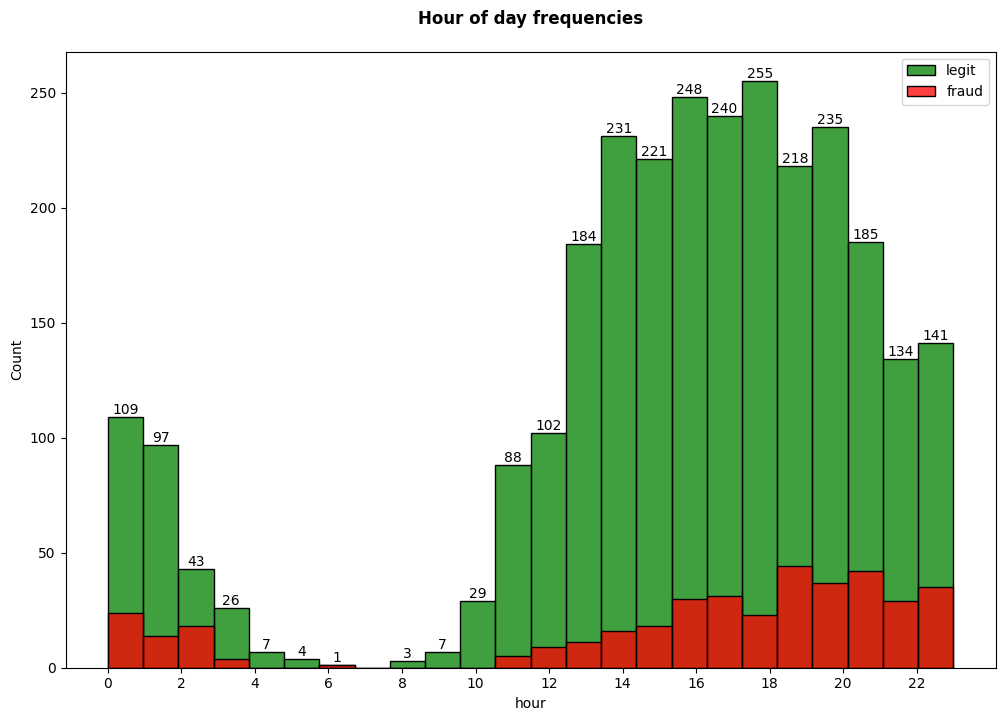

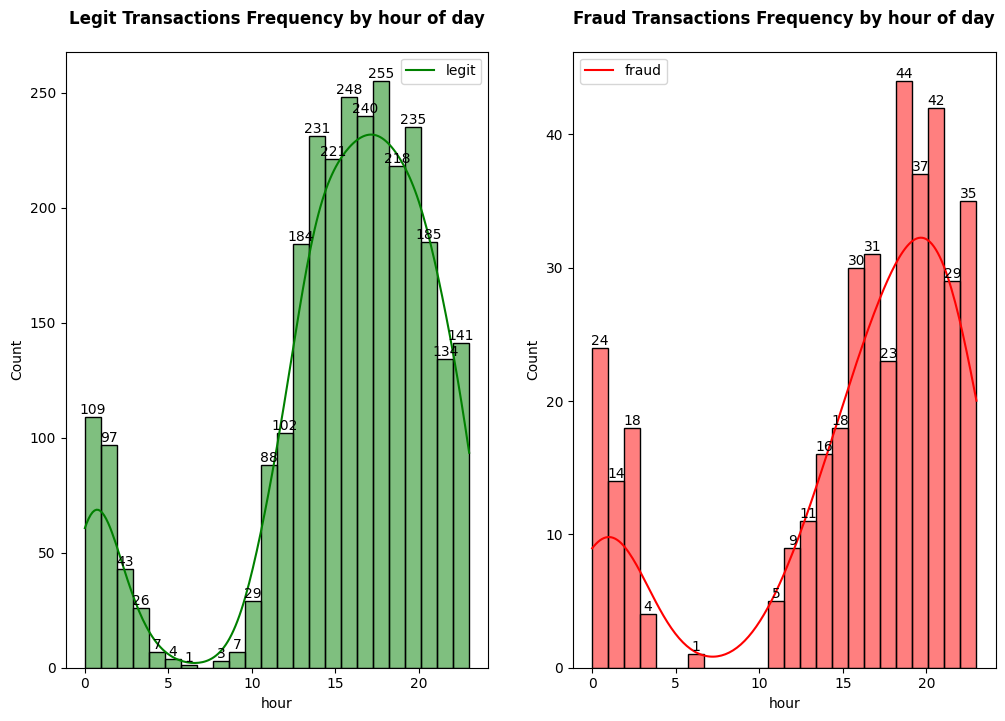

In [55]:
# Analyze frauds by hour

# Create new column with hour
df['hour'] = df.apply(lambda row: row.transaction_date.hour, axis=1)

# Histograms of legit and fraudulent transactions by hour'
## set variables with legit and fraud transactions <= 500 euros
legit_df = df[df.has_cbk == False]
fraud_df = df[df.has_cbk == True]

# Combined chart
fig, ax = plt.subplots(figsize=(12,8))
foo = sns.histplot(legit_df.hour, bins=24, ax=ax, kde=False, color='g')

combined_bar_labels = []
for p in foo.patches:
    h = p.get_height()
    fraud_bar_labels.append(str(h) if h else '')
foo.bar_label(foo.containers[0], labels=combined_bar_labels)


combined_frequency_plot = sns.histplot(fraud_df.hour, bins=24, ax=ax, kde=False, color='r')
combined_frequency_plot.legend(labels=['legit','fraud'])
combined_frequency_plot.set_title("Hour of day frequencies", fontweight='bold', pad=20)
combined_frequency_plot.set_xticks(range(0, 24, 2))



# Legit chart
fig, ax = plt.subplots(1, 2, figsize=(12,8))
legit_plot = sns.histplot(
    x=legit_df.hour, bins=24, ax=ax[0], color='g', kde=True
    )
legit_plot.legend(labels=["legit"])
legit_plot.set_title("Legit Transactions Frequency by hour of day", fontweight='bold', pad=20)
legit_bar_labels = []
for p in legit_plot.patches:
    h = p.get_height()
    legit_bar_labels.append(str(h) if h else '')
legit_plot.bar_label(legit_plot.containers[0], labels=legit_bar_labels)
# legit_plot.set_xticks(range(0, 4001, 500))

# Fraud chart
fraud_plot = sns.histplot(
  x=fraud_df.hour, bins=24, ax=ax[1], color='r', kde=True
  )
fraud_plot.legend(labels=["fraud"])
fraud_plot.set_title("Fraud Transactions Frequency by hour of day", fontweight='bold', pad=20)
fraud_bar_labels = []
for p in fraud_plot.patches:
    h = p.get_height()
    fraud_bar_labels.append(str(h) if h else '')
fraud_plot.bar_label(fraud_plot.containers[0], labels=fraud_bar_labels)
# fraud_plot.set_xticks(range(0, 4001, 500))



Legit               hour
count  2808.000000
mean     15.449074
std       5.812739
min       0.000000
25%      14.000000
50%      17.000000
75%      19.000000
max      23.000000
Fraud              hour
count  391.000000
mean    15.831202
std      6.971896
min      0.000000
25%     14.000000
50%     18.000000
75%     21.000000
max     23.000000


<Axes: title={'center': 'Hour of day correlation'}>

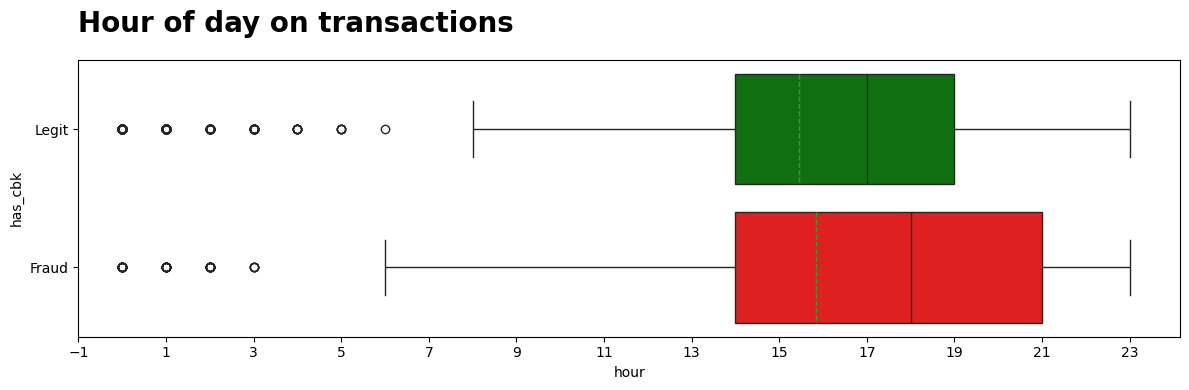

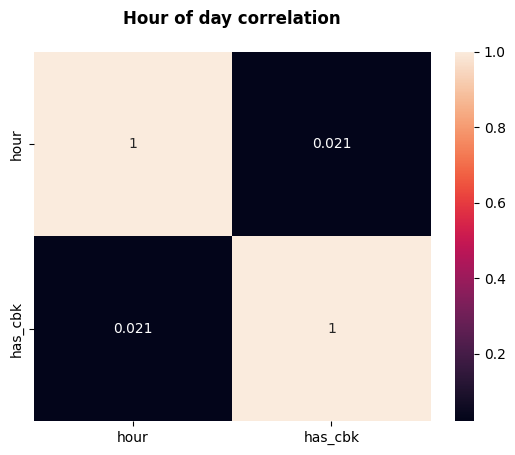

In [43]:
print("Legit", legit_df[['hour']].describe())
print("Fraud", fraud_df[['hour']].describe())

fig, ax = plt.subplots(figsize=(12,4))

sns.boxplot(x=df.hour, y=df.has_cbk, orient='h', meanline=True, showmeans=True,
            palette=['g', 'r'], hue=df.has_cbk, legend=False)
plt.xlim((df.hour.max() + 1))
plt.xticks(range(df.hour.min() - 1, 24, 2))
plt.yticks([0, 1], ['Legit', 'Fraud'])
plt.title('Hour of day on transactions', loc='left', fontsize=20, fontweight='bold', pad=20)

plt.tight_layout()

# Correlation matrix
fig, ax = plt.subplots()
ax.set_title("Hour of day correlation", fontweight='bold', pad=20)
corr = df[['hour', 'has_cbk']].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True)


* Hour and has_bck are not correlated (corr < 0.1)

0.05805892547660312


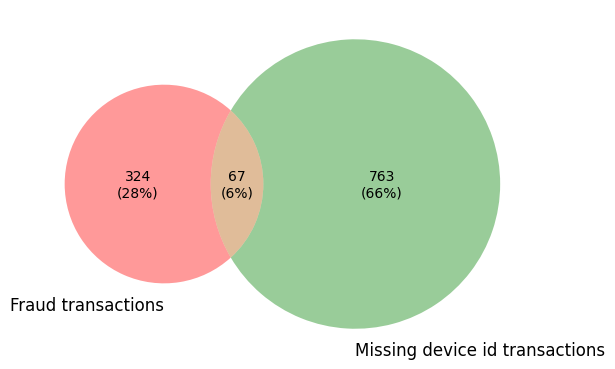

In [12]:
from sklearn.metrics import jaccard_score

df["missing_device_id"] = False
df['missing_device_id'] = np.where(df.device_id.isnull(), True, df.missing_device_id)
print(jaccard_score(df['missing_device_id'], df['has_cbk']))


fraud_df = df[df.has_cbk == True]
missing_devide_id_df = df[df.missing_device_id == True]

fraud_set = set(fraud_df.transaction_id)
missing_device_id_set = set(missing_devide_id_df.transaction_id)
total = len(fraud_set.union(missing_device_id_set))
# set3 = set(['A', 'E', 'F'])

venn2(
    [fraud_set, missing_device_id_set],
     ("Fraud transactions", "Missing device id transactions"),
     subset_label_formatter=lambda x: str(x) + "\n(" + f"{(x/total):1.0%}" + ")")

8.07% of transactions with missing device_id were frauds.

How the device_ids are set in transaction? Could they be used, along with another criteria, to identify frauds?